## DiCE test: How could Mr survive from the sinking of the Titanic?

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
%ls

DiCE_getting_started.ipynb     DiCE_with_advanced_options.ipynb  train.csv
DiCE_with_Titanic_train.ipynb  DiCE_with_private_data.ipynb


In [2]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers # helper functions

# supress deprecation warnings from TF
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

DiCE requires two inputs: a training dataset and a pre-trained ML model. Trained-model wil be generated with tensorflow/keras in this sample. It can also work without access to the full dataset (see this notebook for advanced examples).

### Loading dataset

We use the "titanic" dataset from Kaggle (https://www.kaggle.com/c/titanic/overview). train is given as a csv file with survived column.

In [3]:
df = pd.read_csv('train.csv')

This dataset has 10 features in first place. The outcome is survived which is binarized to 0 (non-suvived) or 1 (survived).

In [4]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# show ratio of survived and non-survived
print(df['survived'].value_counts())
df.info()

0    549
1    342
Name: survived, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


There are some missing values and categorical values so that we need to do feature engineering tasks. I implemented the code from (https://medium.com/@simonli_18826/basic-implementation-of-tensorflow-classification-of-titanic-survival-60a9fbcc7a35) as reference.

In [6]:
# feature engineering for name column
df['title'] = df['name'].str.extract('([A-Za-z]+)\.', expand=True)

# replacing some titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'title': mapping}, inplace=True)
df['title'].value_counts()

Mr        525
Miss      185
Mrs       128
Master     40
Dr          7
Rev         6
Name: title, dtype: int64

Dict for median age for titles: {'Dr': 46.5, 'Master': 3.5, 'Miss': 21.0, 'Mr': 30.0, 'Mrs': 35.0, 'Rev': 46.5}


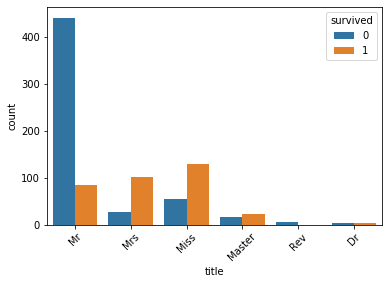

In [7]:
# impute missing age values using median of title groups
title_ages = dict(df.groupby('title')['age'].median())
print("Dict for median age for titles: {}".format(title_ages))

# create a column of the average ages
df['age_med'] = df['title'].apply(lambda x: title_ages[x])

# replace all missing ages with the value in this column
df['age'].fillna(df['age_med'], inplace=True, )
del df['age_med']

# Visualize survival rates of titles
sns.countplot(x='title', data=df, hue='survived')
plt.xticks(rotation=45)
plt.show()

In [8]:
# impute missing fare values using median of pclass groups
class_fares = dict(df.groupby('pclass')['fare'].median())
print("Dict for median fare for pclasses: {}".format(class_fares))

# create a column of the average fares
df['fare_med'] = df['pclass'].apply(lambda x: class_fares[x])

# replace all missing fares with the value in this column
df['fare'].fillna(df['fare_med'], inplace=True, )
del df['fare_med']

Dict for median fare for pclasses: {1: 60.287499999999994, 2: 14.25, 3: 8.05}


In [9]:
# feature engineering for embarked and family_zize, dropped cabin, name, and ticket
df['embarked'].fillna(method='backfill', inplace=True)
df['family_size'] = df['parch'] + df['sibsp']
df.drop(['cabin', 'name', 'ticket'], axis=1, inplace=True)

In [10]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size
0,0,3,male,22.0,1,0,7.2500,S,Mr,1
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1,3,female,26.0,0,0,7.9250,S,Miss,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,0


### Training a custom ML model

Below, we build an Artificial Neural Network based on Keras Tensorflow framework. The models differ slightly based on the version of TensorFlow you use. So the results you get in subsequent sections might be different from what is shown in this notebook.

In [11]:
# seeding random numbers for reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [12]:
sess = tf.compat.v1.InteractiveSession()
d = dice_ml.Data(dataframe=df, continuous_features=['age', 'fare'], outcome_name='survived')

train, _ = d.split_data(d.normalize_data(d.one_hot_encoded_data))
X_train = train.loc[:, train.columns != 'survived']
y_train = train.loc[:, train.columns == 'survived']
X_train.head()

,age,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,sibsp_0,sibsp_1,sibsp_2,...,title_Rev,family_size_0,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_10
873,0.584016,0.017567,0,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
828,0.369721,0.015127,0,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
99,0.420144,0.050749,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
523,0.546199,0.113168,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
132,0.584016,0.028302,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
ann_model = keras.Sequential()
ann_model.add(keras.layers.Dense(20, input_shape=(X_train.shape[1],), 
                                 kernel_regularizer=keras.regularizers.l1(0.001), 
                                 activation=tf.nn.relu))
ann_model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

ann_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.01), 
                  metrics=['accuracy'])
ann_model.fit(X_train, y_train, validation_split=0.20, epochs=100, verbose=0, class_weight={0:1,1:2})
# the training will take some time for 100 epochs.
# you can wait or set verbose=1 to see the progress of training.

In [14]:
# provide the trained ML model to DiCE's model object
backend = 'TF'+tf.__version__[0]
m = dice_ml.Model(model=ann_model, backend=backend)

### Generate diverse counterfactuals

Based on the data object d and the model object m, we can now instantiate the DiCE class for generating explanations.

In [15]:
# initiate DiCE
exp = dice_ml.Dice(d, m)

DiCE provides local explanation for the model m and requires an query input whose outcome needs to be explained. Below we provide a sample input whose outcome is 0 (non-survival) as per the ML model object m. I took this sample from train.cav dataset row 1. His name was Braund, Mr. Owen Harris, 22 years-old man.

In [16]:
# sample taken from raw data at the first row guy
factual_sample = df.iloc[0, 1:].to_dict()
print("Counterfactual sample: {}".format(factual_sample))

Counterfactual sample: {'pclass': 3, 'sex': 'male', 'age': 22.0, 'sibsp': 1, 'parch': 0, 'fare': 7.25, 'embarked': 'S', 'title': 'Mr', 'family_size': 1}


Given the query input, we can now generate counterfactual explanations to show perturbed inputs from the original input where the ML model outputs class 1 (survival).

In [17]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(factual_sample, total_CFs=4, desired_class="opposite")

Diverse Counterfactuals found! total time taken: 00 min 25 sec


In [18]:
# visualize the resutls
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,3,male,22.0,1,0,7.25,S,Mr,1,0.136179



Diverse Counterfactual set (new outcome : 1)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,1,male,22.0,8,0,11.89,C,Mr,1,0.662
1,3,male,22.0,1,0,0.00,S,Master,1,0.968
2,1,female,35.7,2,0,25.43,S,Mr,1,0.871
3,1,female,16.6,1,0,2.54,S,Mrs,1,0.996


In case, if you would like to visualize only the changes made to the query instance, you can set the parameter show_only_changes=True

In [19]:
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,3,male,22.0,1,0,7.25,S,Mr,1,0.136179



Diverse Counterfactual set (new outcome : 1)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,1,-,-,8,-,11.89,C,-,-,0.662
1,-,-,-,-,-,0.0,-,Master,-,0.968
2,1,female,35.7,2,-,25.43,-,-,-,0.871
3,1,female,16.6,-,-,2.54,-,Mrs,-,0.996


Bring the proximity and the features to vary arguments for generating counterfactuals

In [20]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(factual_sample, total_CFs=4, desired_class="opposite", proximity_weight=1.5, diversity_weight=1.0,
                                        features_to_vary=['pclass','age','fare','embarked'])

Diverse Counterfactuals found! total time taken: 01 min 01 sec


In [21]:
# visualize the resutls
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,3,male,22.0,1,0,7.25,S,Mr,1,0.136179



Diverse Counterfactual set (new outcome : 1)


,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,survived
0,1,male,0.7,1,0,6.74,S,Mr,1,0.615
1,1,male,9.5,1,0,0.00,Q,Mr,1,0.733
2,1,male,22.0,1,0,14.01,C,Mr,1,0.714
3,1,male,8.3,1,0,37.11,Q,Mr,1,0.738
